In [1]:
%matplotlib inline
import numpy as np
import decimal
import matplotlib.pyplot as plt
from scipy import interpolate as intp
from scipy import stats
import seaborn as sns
from itertools import compress
from matplotlib.pyplot import cm
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import *

import torch
import torchvision
import torchvision.transforms as transforms

import cv2
from scipy.io import loadmat
from scipy.io import savemat
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def Extract_Orientation_Contrast(frame, ksize, sigma_o, sigma_c, rs):
    """
    Function that estimates the local orientation and contrast at each pixel in the input image frame.
    Inputs:
    frame   - input image
    ksize   - kernel size of the gaussian kernel used to smooth the squared gradients
    sigma_o - standard deviation of the gaussian kernel for estimating orientations
    sigma_c - standard deviation of the gaussian kernel for estimating orientations
    rs      - factor by which to resize the gradient functions
    
    Outputs: 
    Ohat  - estimated orientation
    Chat  - estimated contrast
    """

    # First, compute the gradients
    gx = frame[:,1:] - frame[:,0:-1]
    gx = np.concatenate((gx,np.expand_dims(gx[:,-1],axis=1)),axis=1)

    gy = frame[1:,:] - frame[0:-1,:]
    gy = np.concatenate((gy,np.expand_dims(gy[-1,:],axis=0)),axis=0)

    gxx = gx**2
    gyy = gy**2
    gxy = gx*gy

    # smoothen these sqaured gradients if needed
    gxx = cv2.GaussianBlur(gxx,(ksize,ksize),sigma_o)
    gyy = cv2.GaussianBlur(gyy,(ksize,ksize),sigma_o)
    gxy = cv2.GaussianBlur(gxy,(ksize,ksize),sigma_o)

    # resize these gradient functions
    if rs != 1:
        gxx = cv2.resize(gxx,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)
        gyy = cv2.resize(gyy,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)
        gxy = cv2.resize(gxy,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)

    # Compute local orientations
    Ohat = np.zeros(gxx.shape)

    for i in range(gxx.shape[0]):
        for j in range(gxx.shape[1]):
            M = np.array([[gxx[i,j],gxy[i,j]],[gxy[i,j],gyy[i,j]]])
            D, V = np.linalg.eig(M)
            if D[0] >D[1]:
                ind = 0
            else:
                ind = 1
            Ohat[i,j] = np.arctan2(V[1,ind],V[0,ind])

    # Align the orientation such that 0 radians is north, pi/2 is west and pi is south
    Ohat = np.mod(-Ohat,np.pi)

    Chat = np.sqrt(gx**2 + gy**2)
    Chat = cv2.GaussianBlur(Chat,(ksize,ksize),sigma_c)
    if rs != 1:
        Chat = cv2.resize(Chat,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)
    
    return Ohat, Chat

In [3]:
# file name
# fname = '18142_7_2'
fname = '17797_6_8'

# load the Varma images
data = loadmat('./Platinum_mouse_GNN_data/VarmaMovie_'+fname+'.mat')
VMovie = data['VMovieReq']
del data

# load the ground truth parameters
data = loadmat('./Platinum_mouse_GNN_data/groundtruth_parameters_'+fname+'.mat')
CMapReq = data['CMapReq']
OMapReq = data['OMapReq']
del data

In [6]:
OMapReq[0,22,:,:,100].shape

(28, 48)

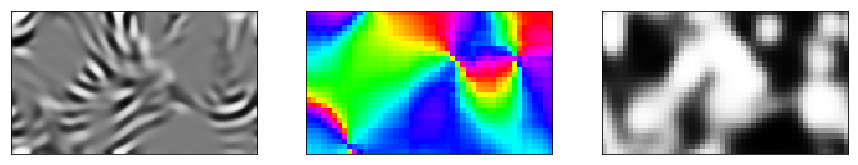

In [10]:
# plot an example image, generative orientation and orientation maps

fig, axes = plt.subplots(1,3,figsize=[15,5])

axes[0].imshow(VMovie[0,22,:,:,100],cmap='gray')
axes[0].set_xticks([]); axes[0].set_yticks([])

im = axes[1].imshow(OMapReq[0,22,:,:,100]/256.0,cmap='hsv')
axes[1].set_xticks([]); axes[1].set_yticks([])
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(CMapReq[0,22,:,:,100]/256.0,cmap='gray')
axes[2].set_xticks([]); axes[2].set_yticks([])
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()


In [5]:
# Extract the local orientation and contrast from the movie frames
OhatReq = np.zeros(OMapReq.shape)
ChatReq = np.zeros(CMapReq.shape)

Nreps, Nc = OMapReq.shape[0:2]
T = OMapReq.shape[4]

for i in range(Nreps):
    for j in range(Nc):
        if np.mod(j,5) == 0:
            print(j)
        for t in range(T):
            OhatReq[i,j,:,:,t], ChatReq[i,j,:,:,t] = Extract_Orientation_Contrast(np.double(VMovie[i,j,:,:,t]), ksize=25, sigma_o=10, sigma_c=15, rs=0.25)


0
5
10
15
20
25
30
35
0
5
10
15
20
25
30
35


In [6]:
# Quantize OhatReq and ChatReq
OhatReq = np.uint8(np.floor(256*OhatReq/np.pi))
ChatReq = np.uint8(np.floor(256*ChatReq/np.max(ChatReq)))



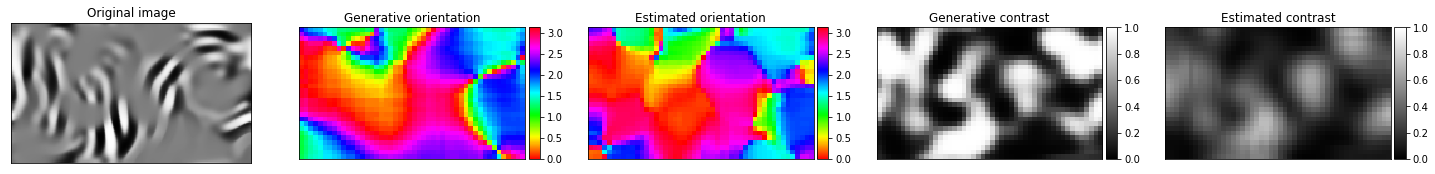

In [7]:
# Obtain the local orientation and contrast from the images
k = 27 # condition
t = 200 # time
frame = np.double(VMovie[0,k,:,:,t])
O_frame = np.double(OMapReq[0,k,:,:,t])
C_frame = np.double(CMapReq[0,k,:,:,t])

Ohat = np.double(OhatReq[0,k,:,:,t])
Chat = np.double(ChatReq[0,k,:,:,t])


# Plotting
fig, axes = plt.subplots(1,5,figsize=[25,5])

axes[0].imshow(frame,cmap='gray')
axes[0].set_xticks([]); axes[0].set_yticks([])
axes[0].set_title('Original image')

im = axes[1].imshow(np.pi*O_frame/256.0,vmin = 0, vmax = np.pi, cmap='hsv')
axes[1].set_xticks([]); axes[1].set_yticks([])
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axes[1].set_title('Generative orientation')

im = axes[2].imshow(np.pi*Ohat/256.0, vmin = 0, vmax = np.pi, cmap='hsv')
axes[2].set_xticks([]); axes[2].set_yticks([])
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axes[2].set_title('Estimated orientation')

im = axes[3].imshow(C_frame/256.0, vmin = 0, vmax = 1, cmap='gray')
axes[3].set_xticks([]); axes[3].set_yticks([])
divider = make_axes_locatable(axes[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axes[3].set_title('Generative contrast')

im = axes[4].imshow(Chat/256.0, vmin = 0, vmax=1, cmap='gray')
axes[4].set_xticks([]); axes[4].set_yticks([])
divider = make_axes_locatable(axes[4])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axes[4].set_title('Estimated contrast')

plt.show()

In [8]:
# save the data
mdict = {'OMapReq': OhatReq, 'CMapReq': ChatReq}
fname = './Platinum_mouse_GNN_data/EstimatedLocalFeatures_' + fname + '.mat'
savemat(fname, mdict)